In [2]:
import pandas as pd
import numpy as np
import calendar
import datetime
import holidays
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

In [3]:
dataset = pd.read_csv('datasets/training_dataset_complete.csv')
dataset.head()

,Unnamed: 0,setmana_epidemiologica,any,data_inici,data_final,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster,holidays,toc_queda,mascareta,temperature
0,53,1,2021,2021-01-04,2021-01-10,29476,2423,470,385,0.0000,0.0,1,1,1,11.8
1,54,2,2021,2021-01-11,2021-01-17,34189,2832,550,495,0.0000,0.0,0,1,1,11.8
2,55,3,2021,2021-01-18,2021-01-24,32651,3075,683,570,0.0000,0.0,0,1,1,11.8
3,56,4,2021,2021-01-25,2021-01-31,30591,3141,728,594,0.0010,0.0,0,1,1,11.8
4,57,5,2021,2021-02-01,2021-02-07,25760,2751,694,440,0.0082,0.0,0,1,1,12.4


In [4]:
dataset_training = dataset.drop(columns = ['Unnamed: 0', 'setmana_epidemiologica', 'any', 'data_final'])
dataset_training_novac = dataset_training.drop(columns = ['pauta_completa', 'booster'])
dataset_training_vac = dataset_training.dropna()
dataset_training_vac.head()


,data_inici,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster,holidays,toc_queda,mascareta,temperature
0,2021-01-04,29476,2423,470,385,0.0000,0.0,1,1,1,11.8
1,2021-01-11,34189,2832,550,495,0.0000,0.0,0,1,1,11.8
2,2021-01-18,32651,3075,683,570,0.0000,0.0,0,1,1,11.8
3,2021-01-25,30591,3141,728,594,0.0010,0.0,0,1,1,11.8
4,2021-02-01,25760,2751,694,440,0.0082,0.0,0,1,1,12.4


## Prediction for CASOS without vac

In [5]:
casos_df = dataset_training_novac.drop(columns = ['hospitalitzacions', 'uci', 'defuncions'])
casos_df.head()

,data_inici,casos,holidays,toc_queda,mascareta,temperature
0,2021-01-04,29476,1,1,1,11.8
1,2021-01-11,34189,0,1,1,11.8
2,2021-01-18,32651,0,1,1,11.8
3,2021-01-25,30591,0,1,1,11.8
4,2021-02-01,25760,0,1,1,12.4


In [6]:
casos_df = dataset_training[['data_inici', 'casos', 'holidays', 'toc_queda', 'mascareta', 'temperature']]
casos_df['data_inici'] = pd.to_datetime(casos_df['data_inici'], format = "%Y/%m/%d")

max_casos = casos_df.casos.max()
min_casos = casos_df.casos.min()

# El test es fa en la sisena onada, durant les dates 30/05/2022 - 19/09/2022
index1 = casos_df.index[casos_df['data_inici'] == datetime.datetime(2022, 5, 30)]
index2 = casos_df.index[casos_df['data_inici'] == datetime.datetime(2022, 9, 19)]
casos_df = casos_df.drop(columns = ['data_inici'])

casos_df = (casos_df-casos_df.min())/(casos_df.max()-casos_df.min())


#We create the columns with the values of the previous weeks --> attributes
casos_df['cases-1'] = casos_df['casos'].shift(1)
casos_df['cases-2'] = casos_df['casos'].shift(2)
casos_df['cases-3'] = casos_df['casos'].shift(3)
casos_df['cases-4'] = casos_df['casos'].shift(4)
casos_df['cases-5'] = casos_df['casos'].shift(5)

#We create the target column with the predictions for next week
casos_df['target1'] = casos_df['casos'].shift(-1)
casos_df['target3'] = casos_df['casos'].shift(-3)
casos_df['target5'] = casos_df['casos'].shift(-5)

casos_df = casos_df.iloc[5:,:]
#casos_df = casos_df.iloc[:-1, :]
casos_df.head()

/var/folders/v7/n70jpygd74d0y1kxzrd_w5y00000gn/T/ipykernel_8597/4045443680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casos_df['data_inici'] = pd.to_datetime(casos_df['data_inici'], format = "%Y/%m/%d")


,casos,holidays,toc_queda,mascareta,temperature,cases-1,cases-2,cases-3,cases-4,cases-5,target1,target3,target5
5,0.082380,0.0,1.0,1.0,0.041958,0.107829,0.130740,0.140510,0.147804,0.125452,0.076541,0.062707,0.063841
6,0.076541,0.0,1.0,1.0,0.041958,0.082380,0.107829,0.130740,0.140510,0.147804,0.068436,0.059819,0.071040
7,0.068436,0.0,1.0,1.0,0.041958,0.076541,0.082380,0.107829,0.130740,0.140510,0.062707,0.063841,0.057694
8,0.062707,0.0,1.0,1.0,0.167832,0.068436,0.076541,0.082380,0.107829,0.130740,0.059819,0.071040,0.069911
9,0.059819,0.0,1.0,1.0,0.167832,0.062707,0.068436,0.076541,0.082380,0.107829,0.063841,0.057694,0.070741


#### CASOS SETMANA 1

Epoch 1/100


2024-01-05 19:06:46.431070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 120ms/step - loss: 0.0377 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 193929.8750
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0281 - mean_absolute_error: 0.1335 - mean_absolute_percentage_error: 453770.8438
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0206 - mean_absolute_error: 0.1125 - mean_absolute_percentage_error: 412964.6250
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0151 - mean_absolute_error: 0.0834 - mean_absolute_percentage_error: 321073.6562
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0124 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 269507.9062
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0101 - mean_absolute_error: 0.0648 - mean_absolute_percentage_error: 271032.0625
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0084 - 

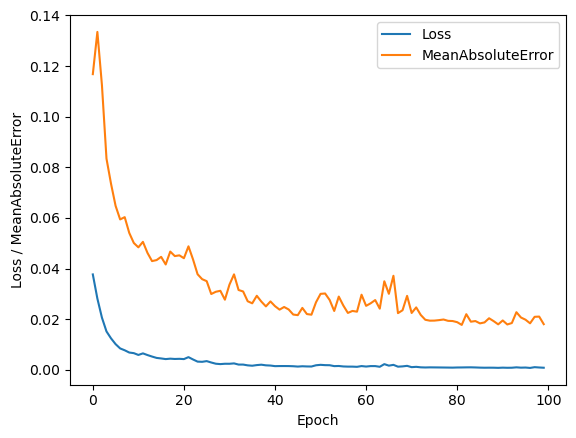

2024-01-05 19:06:53.869719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 310ms/step - loss: 0.0028 - mean_absolute_error: 0.0485 - mean_absolute_percentage_error: 763.9648
Loss Value Test: 0.00283247628249228
MeanAbsoluteError Test: 13245.257270611823
MeanAbsolutePercentageError Test: 763.96484375


In [24]:

casos_df1 = casos_df.iloc[:-1, :]
casos_df1 = casos_df1.drop(columns = ['target3', 'target5'])

Test_df = casos_df1.loc[index1[0]:index2[0]]
Training_df = casos_df1.drop(casos_df1.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target1']).values.astype(np.float32)
X_test1 = Test_df.drop(columns = ['target1']).values.astype(np.float32)

y_train = Training_df[['target1']].values.astype(np.float32)
y_test1 = Test_df[['target1']].values.astype(np.float32)

n_outputs = 1

# # DEFINE THE FEEDFORWARD NEURAL NETWORK
# n_neurons_per_hidden_layer = [5000, 1000, 500, 100, 25]

# model_casos1 = tf.keras.models.Sequential()
# model_casos1.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],1)))
# for neurons in n_neurons_per_hidden_layer:
#   model_casos1.add(tf.keras.layers.Dense(neurons, activation="elu", kernel_initializer = "he_normal", 
#             kernel_regularizer=tf.keras.regularizers.l1(0.001)))
#   model_casos1.add(tf.keras.layers.BatchNormalization())
# model_casos1.add(tf.keras.layers.Dense(n_outputs, activation="linear")) #output linear layer

# model_casos1.summary()

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_casos1 = tf.keras.models.Sequential()
model_casos1.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_casos1.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_casos1.add(tf.keras.layers.Flatten())
model_casos1.add(tf.keras.layers.Dense(50, activation='relu'))
model_casos1.add(tf.keras.layers.Dense(1))

model_casos1.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError', 'MeanAbsolutePercentageError'])


history = model_casos1.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error, mape = model_casos1.evaluate(X_test1, y_test1)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))
print("MeanAbsolutePercentageError Test: " + str(mape))

#### CASOS SETMANA 3

Epoch 1/100


/Users/danteadami/miniconda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2024-01-05 19:11:29.362669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 107ms/step - loss: 0.0508 - mean_absolute_error: 0.1113 - mean_absolute_percentage_error: 87115.5938
Epoch 2/100
4/4 [==============================] - 0s 61ms/step - loss: 0.0404 - mean_absolute_error: 0.0983 - mean_absolute_percentage_error: 540699.5000
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0368 - mean_absolute_error: 0.1173 - mean_absolute_percentage_error: 1049826.8750
Epoch 4/100
4/4 [==============================] - 0s 60ms/step - loss: 0.0345 - mean_absolute_error: 0.1263 - mean_absolute_percentage_error: 1078366.6250
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0335 - mean_absolute_error: 0.1235 - mean_absolute_percentage_error: 1085893.2500
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0318 - mean_absolute_error: 0.1149 - mean_absolute_percentage_error: 1018976.3125
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0308

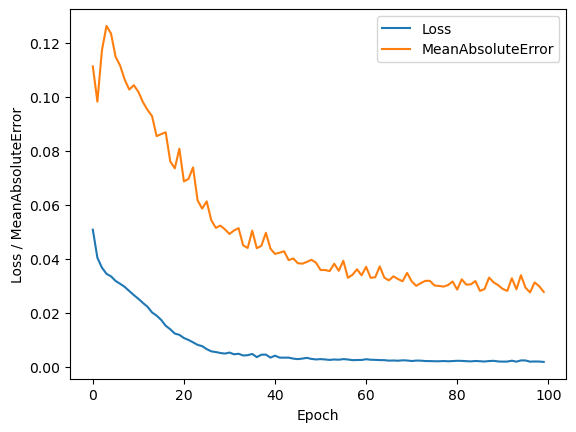

2024-01-05 19:11:38.611991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 388ms/step - loss: 0.0223 - mean_absolute_error: 0.1365 - mean_absolute_percentage_error: 2303.9578
Loss Value Test: 0.02234271727502346
MeanAbsoluteError Test: 31801.871724635363


In [33]:
casos_df3 = casos_df.iloc[:-3, :]
casos_df3 = casos_df3.drop(columns = ['target1', 'target5'])

Test_df = casos_df3.loc[index1[0]:index2[0]]
Training_df = casos_df3.drop(casos_df3.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target3']).values.astype(np.float32)
X_test3 = Test_df.drop(columns = ['target3']).values.astype(np.float32)

y_train = Training_df[['target3']].values.astype(np.float32)
y_test3 = Test_df[['target3']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# # DEFINE THE FEEDFORWARD NEURAL NETWORK
# n_neurons_per_hidden_layer = [5000, 1000, 500, 100, 25]

# model_casos3 = tf.keras.models.Sequential()
# model_casos3.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],1)))
# for neurons in n_neurons_per_hidden_layer:
#   model_casos3.add(tf.keras.layers.Dense(neurons, activation="elu", kernel_initializer = "he_normal", 
#             kernel_regularizer=tf.keras.regularizers.l1(0.001)))
#   model_casos3.add(tf.keras.layers.BatchNormalization())
# model_casos3.add(tf.keras.layers.Dense(n_outputs, activation="linear")) #output linear layer

# model_casos3.summary()

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_casos3 = tf.keras.models.Sequential()
model_casos3.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_casos3.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_casos3.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_casos3.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
model_casos3.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_casos3.add(tf.keras.layers.Flatten())
model_casos3.add(tf.keras.layers.Dense(100, activation='relu'))
model_casos3.add(tf.keras.layers.Dense(n_outputs))

model_casos3.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError', 'MeanAbsolutePercentageError'])

opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False, clipnorm=1.0, clipvalue=0.5)
model_casos3.compile(optimizer=opt, loss='mean_squared_error', metrics=['MeanAbsoluteError', 'MeanAbsolutePercentageError'])

history = model_casos3.fit(X_train, y_train, epochs=100, batch_size=20)

loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error, mape = model_casos3.evaluate(X_test3, y_test3)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))


#### Casos Setmana 5

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 8, 32)             128       
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 32)             3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 32)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 16)             1552      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 16)            0         
 1D)                                                             
                                                                 
 flatten_15 (Flatten)        (None, 16)              

/Users/danteadami/miniconda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2024-01-05 19:10:34.563404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 5s 247ms/step - loss: 0.0507 - mean_absolute_error: 0.1139 - mean_absolute_percentage_error: 128935.0234
Epoch 2/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0400 - mean_absolute_error: 0.1034 - mean_absolute_percentage_error: 449632.2188
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0379 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 1163828.8750
Epoch 4/100
4/4 [==============================] - 0s 94ms/step - loss: 0.0374 - mean_absolute_error: 0.1386 - mean_absolute_percentage_error: 1244888.8750
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0350 - mean_absolute_error: 0.1257 - mean_absolute_percentage_error: 1173611.7500
Epoch 6/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0335 - mean_absolute_error: 0.1136 - mean_absolute_percentage_error: 1009541.6250
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.032

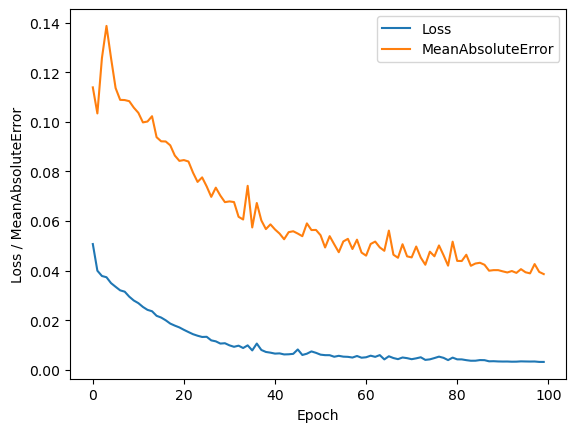

2024-01-05 19:10:47.397803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 424ms/step - loss: 0.0047 - mean_absolute_error: 0.0651 - mean_absolute_percentage_error: 831.9114
Loss Value Test: 0.004688710439950228
MeanAbsoluteError Test: 16745.37577778846


In [31]:
casos_df5 = casos_df.iloc[:-5, :]
casos_df5 = casos_df5.drop(columns = ['target1', 'target3'])

Test_df = casos_df5.loc[index1[0]:index2[0]]
Training_df = casos_df5.drop(casos_df5.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target5']).values.astype(np.float32)
X_test5 = Test_df.drop(columns = ['target5']).values.astype(np.float32)

y_train = Training_df[['target5']].values.astype(np.float32)
y_test5 = Test_df[['target5']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# n_neurons_per_hidden_layer = [5000, 1000, 500, 100, 25]

# model_casos5 = tf.keras.models.Sequential()
# model_casos5.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],1)))
# for neurons in n_neurons_per_hidden_layer:
#   model_casos5.add(tf.keras.layers.Dense(neurons, activation="elu", kernel_initializer = "he_normal", 
#             kernel_regularizer=tf.keras.regularizers.l1(0.001)))
#   model_casos5.add(tf.keras.layers.BatchNormalization())
# model_casos5.add(tf.keras.layers.Dense(n_outputs, activation="linear")) #output linear layer

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_casos5 = tf.keras.models.Sequential()
model_casos5.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_casos5.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_casos5.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_casos5.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
model_casos5.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_casos5.add(tf.keras.layers.Flatten())
model_casos5.add(tf.keras.layers.Dense(100, activation='relu'))
model_casos5.add(tf.keras.layers.Dense(n_outputs))


model_casos5.summary()

opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False, clipnorm=1.0, clipvalue=0.5)
model_casos5.compile(optimizer=opt, loss='mean_squared_error', metrics=['MeanAbsoluteError', 'MeanAbsolutePercentageError'])

history = model_casos5.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
#loss, mean_absolute_error, rmse = model_casos5.evaluate(X_test5, y_test5)
loss, mean_absolute_error, mape = model_casos5.evaluate(X_test5, y_test5)

print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))

#### Visualitzacio CASOS

1/1 [==============================] - 0s 18ms/step


2024-01-05 19:11:41.356197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Mean Absolute Error 1 Week:  13245.256947175325
Mean Absolute Error 3 Weeks:  31801.87495900033
Mean Absolute Error 5 Weeks:  16745.376101224956


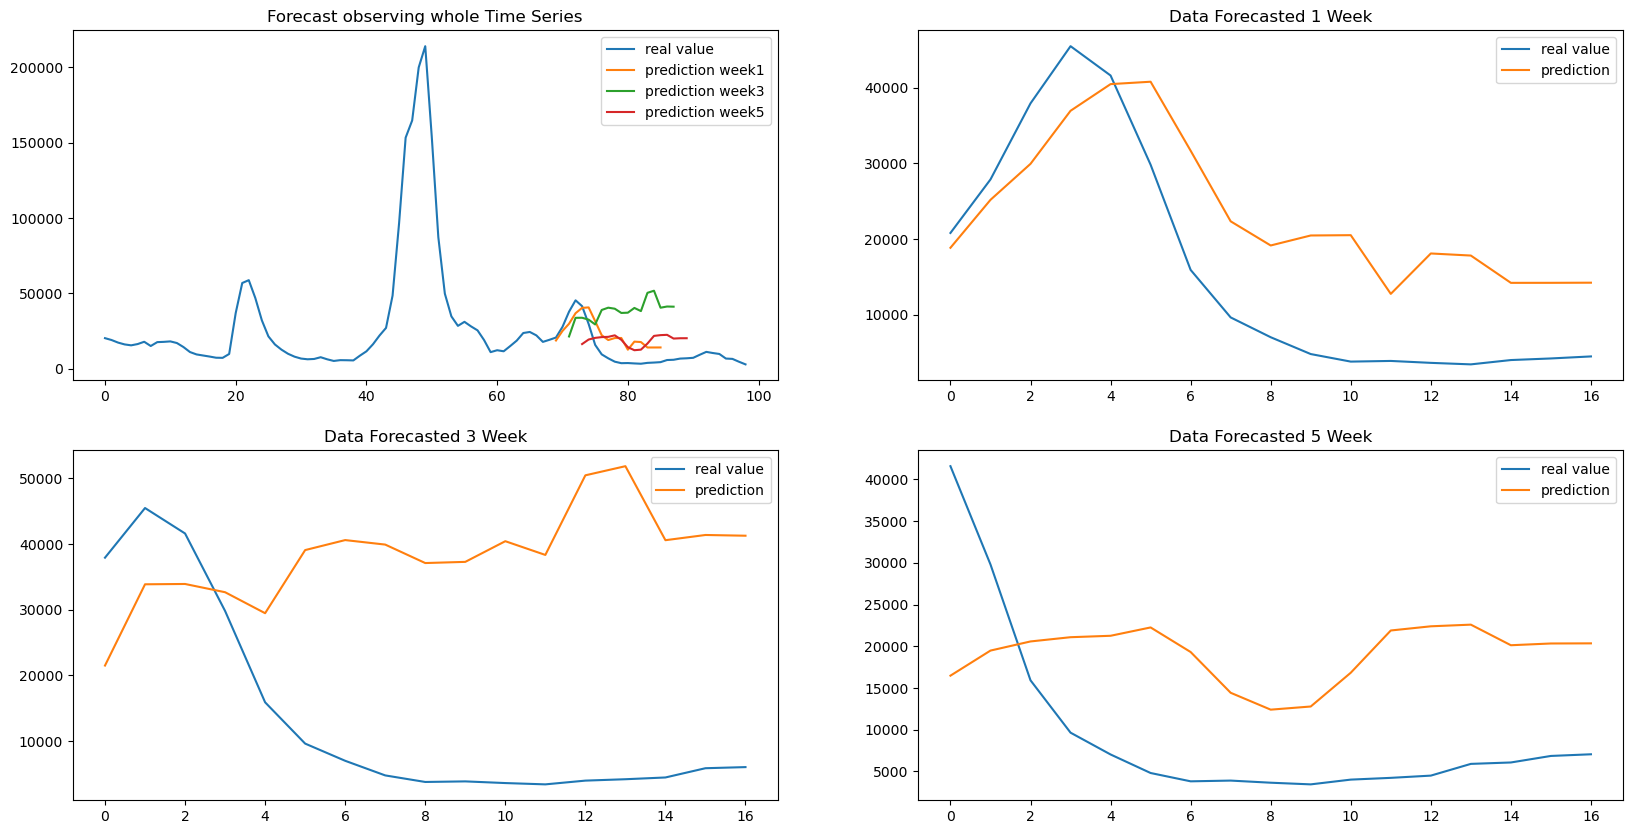

In [34]:
#create the prediction
y_pred1 = model_casos1.predict(X_test1)
y_pred3 = model_casos3.predict(X_test3)
y_pred5 = model_casos5.predict(X_test5)

y_pred1[y_pred1<0]=0
y_pred3[y_pred3<0]=0
y_pred5[y_pred5<0]=0

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
#plt.plot(y_test*(max_casos-min_casos)+min_casos, label = 'real value')
axs[0,0].plot(np.arange(0, len(casos_df)), casos_df['casos']*(max_casos-min_casos)+min_casos, label = 'real value')
start_index1 = np.where(casos_df['casos'].values.astype(np.float32) == y_test1[0][0])
start_index3 = np.where(casos_df['casos'].values.astype(np.float32) == y_test3[0][0])
start_index5 = np.where(casos_df['casos'].values.astype(np.float32) == y_test5[0][0])
axs[0,0].plot(np.arange(start_index1[0][0], len(y_pred1)+start_index1[0][0]), y_pred1*(max_casos-min_casos)+min_casos, label = 'prediction week1')
axs[0,0].plot(np.arange(start_index3[0][0], len(y_pred3)+start_index3[0][0]), y_pred3*(max_casos-min_casos)+min_casos, label = 'prediction week3')
axs[0,0].plot(np.arange(start_index5[0][0], len(y_pred5)+start_index5[0][0]), y_pred5*(max_casos-min_casos)+min_casos, label = 'prediction week5')
axs[0,0].legend()
axs[0,0].set_title("Forecast observing whole Time Series")

axs[0,1].plot(y_test1*(max_casos-min_casos)+min_casos, label = 'real value')
axs[0,1].plot(y_pred1*(max_casos-min_casos)+min_casos, label = 'prediction')
axs[0,1].legend()
axs[0,1].set_title("Data Forecasted 1 Week")

axs[1,0].plot(y_test3*(max_casos-min_casos)+min_casos, label = 'real value')
axs[1,0].plot(y_pred3*(max_casos-min_casos)+min_casos, label = 'prediction')
axs[1,0].legend()
axs[1,0].set_title("Data Forecasted 3 Week")

axs[1,1].plot(y_test5*(max_casos-min_casos)+min_casos, label = 'real value')
axs[1,1].plot(y_pred5*(max_casos-min_casos)+min_casos, label = 'prediction')
axs[1,1].legend()
axs[1,1].set_title("Data Forecasted 5 Week")
print("Mean Absolute Error 1 Week: " , np.mean(abs(y_test1 - y_pred1)*(max_casos-min_casos)+min_casos))
print("Mean Absolute Error 3 Weeks: " , np.mean(abs(y_test3 - y_pred3)*(max_casos-min_casos)+min_casos))
print("Mean Absolute Error 5 Weeks: " , np.mean(abs(y_test5 - y_pred5)*(max_casos-min_casos)+min_casos))

## Predictions HOSPITALITZACIONS

In [ ]:
hosp_df = dataset_training[['data_inici', 'casos', 'hospitalitzacions', 'holidays', 'toc_queda', 'mascareta', 'temperature']]
hosp_df['data_inici'] = pd.to_datetime(hosp_df['data_inici'], format = "%Y/%m/%d")

max_casos = hosp_df.casos.max()
min_casos = hosp_df.casos.min()
max_hosp = hosp_df.hospitalitzacions.max()
min_hosp = hosp_df.hospitalitzacions.min()

# El test es fa en la sisena onada, durant les dates 30/05/2022 - 19/09/2022
index1 = hosp_df.index[hosp_df['data_inici'] == datetime.datetime(2022, 5, 30)]
index2 = hosp_df.index[hosp_df['data_inici'] == datetime.datetime(2022, 9, 19)]
hosp_df = hosp_df.drop(columns = ['data_inici'])

hosp_df = (hosp_df-hosp_df.min())/(hosp_df.max()-hosp_df.min())


#We create the columns with the values of the previous weeks --> attributes
hosp_df['cases-1'] = hosp_df['casos'].shift(1)
hosp_df['cases-2'] = hosp_df['casos'].shift(2)
hosp_df['cases-3'] = hosp_df['casos'].shift(3)
hosp_df['cases-4'] = hosp_df['casos'].shift(4)
hosp_df['cases-5'] = hosp_df['casos'].shift(5)

hosp_df['hosp-1'] = hosp_df['hospitalitzacions'].shift(1)
hosp_df['hosp-2'] = hosp_df['hospitalitzacions'].shift(2)
hosp_df['hosp-3'] = hosp_df['hospitalitzacions'].shift(3)
hosp_df['hosp-4'] = hosp_df['hospitalitzacions'].shift(4)
hosp_df['hosp-5'] = hosp_df['hospitalitzacions'].shift(5)

#We create the target column with the predictions for next week
hosp_df['target1'] = hosp_df['hospitalitzacions'].shift(-1)
hosp_df['target3'] = hosp_df['hospitalitzacions'].shift(-3)
hosp_df['target5'] = hosp_df['hospitalitzacions'].shift(-5)

hosp_df = hosp_df.iloc[5:,:]
hosp_df.head()

<ipython-input-19-db987283a77b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp_df['data_inici'] = pd.to_datetime(hosp_df['data_inici'], format = "%Y/%m/%d")


,casos,hospitalitzacions,holidays,toc_queda,mascareta,temperature,cases-1,cases-2,cases-3,cases-4,cases-5,hosp-1,hosp-2,hosp-3,hosp-4,hosp-5,target1,target3,target5
5,0.080810,0.753582,0.0,1.0,1.0,0.041958,0.106258,0.129302,0.138690,0.146390,0.123977,0.875836,1.000000,0.978988,0.901624,0.771410,0.642471,0.518625,0.451767
6,0.075064,0.642471,0.0,1.0,1.0,0.041958,0.080810,0.106258,0.129302,0.138690,0.146390,0.753582,0.875836,1.000000,0.978988,0.901624,0.563196,0.490608,0.469277
7,0.066914,0.563196,0.0,1.0,1.0,0.041958,0.075064,0.080810,0.106258,0.129302,0.138690,0.642471,0.753582,0.875836,1.000000,0.978988,0.518625,0.451767,0.510029
8,0.061045,0.518625,0.0,1.0,1.0,0.167832,0.066914,0.075064,0.080810,0.106258,0.129302,0.563196,0.642471,0.753582,0.875836,1.000000,0.490608,0.469277,0.564152
9,0.058162,0.490608,0.0,1.0,1.0,0.167832,0.061045,0.066914,0.075064,0.080810,0.106258,0.518625,0.563196,0.642471,0.753582,0.875836,0.451767,0.510029,0.544731


#### Hospitalitzacions Setmana 1

Epoch 1/100
4/4 [==============================] - 1s 6ms/step - loss: 1.5445 - mean_absolute_error: 0.3398 - root_mean_squared_error: 0.4035
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8059 - mean_absolute_error: 0.2397 - root_mean_squared_error: 0.3074
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6836 - mean_absolute_error: 0.1788 - root_mean_squared_error: 0.2301
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6408 - mean_absolute_error: 0.1556 - root_mean_squared_error: 0.1845
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6379 - mean_absolute_error: 0.1528 - root_mean_squared_error: 0.1801
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.6509 - mean_absolute_error: 0.1650 - root_mean_squared_error: 0.1957
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6453 - mean_absolute_error: 0.1605 - root_mean_squared_error: 0.1889
Epoch 

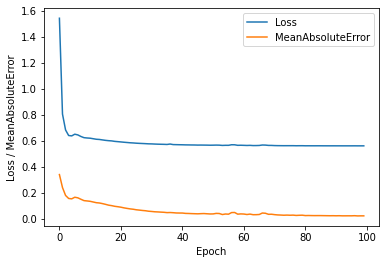

1/1 [==============================] - 0s 165ms/step - loss: 0.6015 - mean_absolute_error: 0.1106 - root_mean_squared_error: 0.1346
Loss Value Test: 0.6015051007270813
MeanAbsoluteError Test: 26496.226310253143


In [ ]:
hosp_df1 = hosp_df.iloc[:-1, :]
hosp_df1 = hosp_df1.drop(columns = ['target3', 'target5'])

Test_df = hosp_df1.loc[index1[0]:index2[0]]
Training_df = hosp_df1.drop(hosp_df1.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target1']).values.astype(np.float32)
X_test1 = Test_df.drop(columns = ['target1']).values.astype(np.float32)

y_train = Training_df[['target1']].values.astype(np.float32)
y_test1 = Test_df[['target1']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_hosp1 = tf.keras.models.Sequential()
model_hosp1.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_hosp1.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_hosp1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_hosp1.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
model_hosp1.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_hosp1.add(tf.keras.layers.Flatten())
model_hosp1.add(tf.keras.layers.Dense(100, activation='relu'))
model_hosp1.add(tf.keras.layers.Dense(n_outputs))
model_hosp1.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['MeanAbsoluteError', 'RootMeanSquaredError'])

history = model_hosp1.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error, rmse = model_hosp1.evaluate(X_test1, y_test1)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))

#### Hospitalitzacions Setmana 3

Epoch 1/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1555 - mean_absolute_error: 0.3198
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0618 - mean_absolute_error: 0.2099
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0622 - mean_absolute_error: 0.2153
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0438 - mean_absolute_error: 0.1802
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0414 - mean_absolute_error: 0.1679
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0378 - mean_absolute_error: 0.1580
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0322 - mean_absolute_error: 0.1465
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0286 - mean_absolute_error: 0.1411
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0271 - mean_absolute_error: 0.1363
Epoch 10/100
4/4 [==========

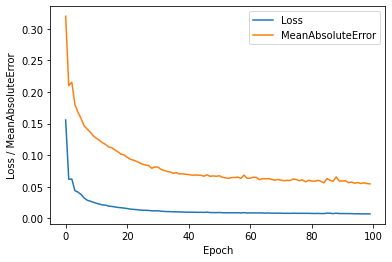

1/1 [==============================] - 0s 134ms/step - loss: 0.0254 - mean_absolute_error: 0.1504
Loss Value Test: 0.025351807475090027
MeanAbsoluteError Test: 34830.07188940048


In [ ]:
hosp_df3 = hosp_df.iloc[:-3, :]
hosp_df3 = hosp_df3.drop(columns = ['target1', 'target5'])

Test_df = hosp_df3.loc[index1[0]:index2[0]]
Training_df = hosp_df3.drop(hosp_df3.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target3']).values.astype(np.float32)
X_test3 = Test_df.drop(columns = ['target3']).values.astype(np.float32)

y_train = Training_df[['target3']].values.astype(np.float32)
y_test3 = Test_df[['target3']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_hosp3 = tf.keras.models.Sequential()
model_hosp3.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_hosp3.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_hosp3.add(tf.keras.layers.Flatten())
model_hosp3.add(tf.keras.layers.Dense(50, activation='relu'))
model_hosp3.add(tf.keras.layers.Dense(1))

model_hosp3.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_hosp3.fit(X_train, y_train, epochs=100, batch_size=20)

loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_hosp3.evaluate(X_test3, y_test3)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))


#### Hospitalitzacions Setmana 5

Epoch 1/100
4/4 [==============================] - 0s 3ms/step - loss: 0.1257 - mean_absolute_error: 0.2855
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0874 - mean_absolute_error: 0.2530
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0721 - mean_absolute_error: 0.2252
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0609 - mean_absolute_error: 0.1958
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0587 - mean_absolute_error: 0.1929
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0510 - mean_absolute_error: 0.1814
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0471 - mean_absolute_error: 0.1777
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0450 - mean_absolute_error: 0.1751
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0416 - mean_absolute_error: 0.1658
Epoch 10/100
4/4 [==========

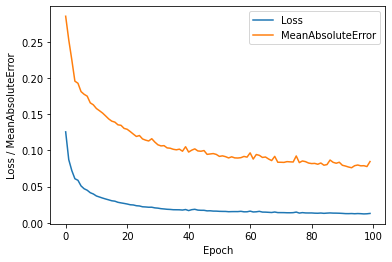

1/1 [==============================] - 0s 111ms/step - loss: 0.0408 - mean_absolute_error: 0.1875
Loss Value Test: 0.040753092616796494
MeanAbsoluteError Test: 42581.86296570301


In [ ]:
hosp_df5 = hosp_df.iloc[:-5, :]
hosp_df5 = hosp_df5.drop(columns = ['target1', 'target3'])

Test_df = hosp_df5.loc[index1[0]:index2[0]]
Training_df = hosp_df5.drop(hosp_df5.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target5']).values.astype(np.float32)
X_test5 = Test_df.drop(columns = ['target5']).values.astype(np.float32)

y_train = Training_df[['target5']].values.astype(np.float32)
y_test5 = Test_df[['target5']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_hosp5 = tf.keras.models.Sequential()
model_hosp5.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_hosp5.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_hosp5.add(tf.keras.layers.Flatten())
model_hosp5.add(tf.keras.layers.Dense(50, activation='relu'))
model_hosp5.add(tf.keras.layers.Dense(1))

model_hosp5.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_hosp5.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
#loss, mean_absolute_error, rmse = model_casos5.evaluate(X_test5, y_test5)
loss, mean_absolute_error = model_hosp5.evaluate(X_test5, y_test5)

print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))

#### Visualitzacio Hospitalitzacions

1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 70ms/step
Mean Absolute Error 1 Week:  347.33182
Mean Absolute Error 3 Week:  472.45422
Mean Absolute Error 5 Week:  588.8378


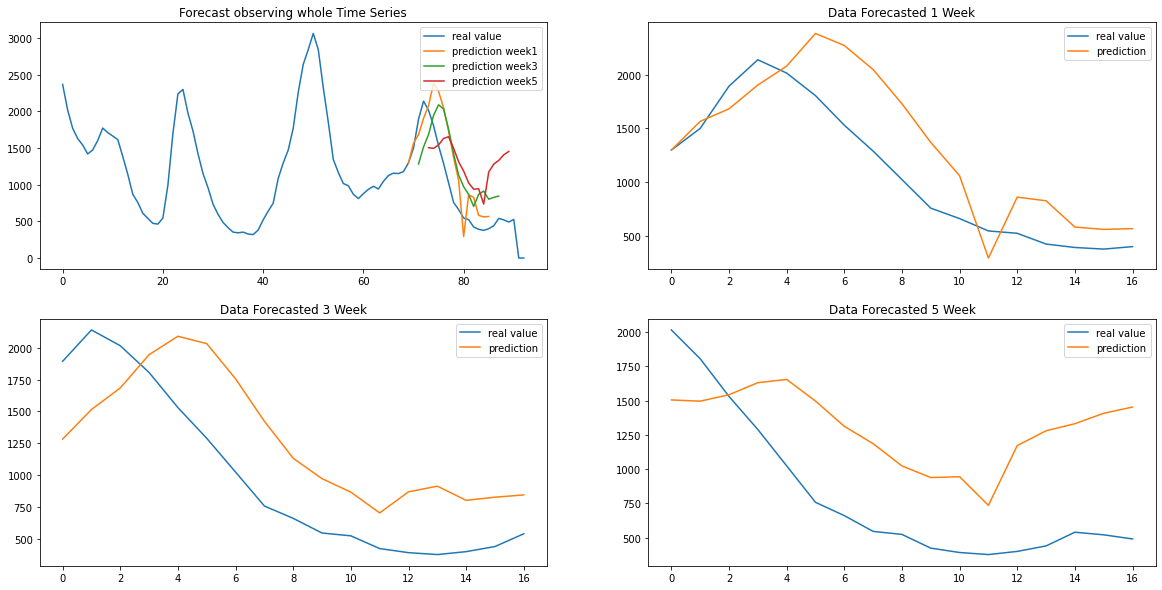

In [ ]:
#create the prediction
y_pred1 = model_hosp1.predict(X_test1)
y_pred3 = model_hosp3.predict(X_test3)
y_pred5 = model_hosp5.predict(X_test5)

y_pred1[y_pred1<0]=0
y_pred3[y_pred3<0]=0
y_pred5[y_pred5<0]=0

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
#plt.plot(y_test*(max_casos-min_casos)+min_casos, label = 'real value')
axs[0,0].plot(np.arange(0, len(hosp_df)), hosp_df['hospitalitzacions']*(max_hosp-min_hosp)+min_hosp, label = 'real value')
start_index1 = np.where(hosp_df['hospitalitzacions'].values.astype(np.float32) == y_test1[0][0])
start_index3 = np.where(hosp_df['hospitalitzacions'].values.astype(np.float32) == y_test3[0][0])
start_index5 = np.where(hosp_df['hospitalitzacions'].values.astype(np.float32) == y_test5[0][0])
axs[0,0].plot(np.arange(start_index1[0][0], len(y_pred1)+start_index1[0][0]), y_pred1*(max_hosp-min_hosp)+min_hosp, label = 'prediction week1')
axs[0,0].plot(np.arange(start_index3[0][0], len(y_pred3)+start_index3[0][0]), y_pred3*(max_hosp-min_hosp)+min_hosp, label = 'prediction week3')
axs[0,0].plot(np.arange(start_index5[0][0], len(y_pred5)+start_index5[0][0]), y_pred5*(max_hosp-min_hosp)+min_hosp, label = 'prediction week5')
axs[0,0].legend()
axs[0,0].set_title("Forecast observing whole Time Series")

axs[0,1].plot(y_test1*(max_hosp-min_hosp)+min_hosp, label = 'real value')
axs[0,1].plot(y_pred1*(max_hosp-min_hosp)+min_hosp, label = 'prediction')
axs[0,1].legend()
axs[0,1].set_title("Data Forecasted 1 Week")

axs[1,0].plot(y_test3*(max_hosp-min_hosp)+min_hosp, label = 'real value')
axs[1,0].plot(y_pred3*(max_hosp-min_hosp)+min_hosp, label = 'prediction')
axs[1,0].legend()
axs[1,0].set_title("Data Forecasted 3 Week")

axs[1,1].plot(y_test5*(max_hosp-min_hosp)+min_hosp, label = 'real value')
axs[1,1].plot(y_pred5*(max_hosp-min_hosp)+min_hosp, label = 'prediction')
axs[1,1].legend()
axs[1,1].set_title("Data Forecasted 5 Week")
print("Mean Absolute Error 1 Week: " , np.mean(abs(y_test1 - y_pred1)*(max_hosp-min_hosp)+min_hosp))
print("Mean Absolute Error 3 Week: " , np.mean(abs(y_test3 - y_pred3)*(max_hosp-min_hosp)+min_hosp))
print("Mean Absolute Error 5 Week: " , np.mean(abs(y_test5 - y_pred5)*(max_hosp-min_hosp)+min_hosp))

## Prediccions UCI

In [ ]:
uci_df = dataset_training[['data_inici', 'casos', 'hospitalitzacions', 'uci', 'holidays', 'toc_queda', 'mascareta', 'temperature']]
uci_df['data_inici'] = pd.to_datetime(uci_df['data_inici'], format = "%Y/%m/%d")

max_uci = uci_df.hospitalitzacions.max()
min_uci = uci_df.hospitalitzacions.min()

# El test es fa en la sisena onada, durant les dates 30/05/2022 - 19/09/2022
index1 = uci_df.index[uci_df['data_inici'] == datetime.datetime(2022, 5, 30)]
index2 = uci_df.index[uci_df['data_inici'] == datetime.datetime(2022, 9, 19)]
uci_df = uci_df.drop(columns = ['data_inici'])

uci_df = (uci_df-uci_df.min())/(uci_df.max()-uci_df.min())


#We create the columns with the values of the previous weeks --> attributes
uci_df['uci-1'] = uci_df['uci'].shift(1)
uci_df['uci-2'] = uci_df['uci'].shift(2)
uci_df['uci-3'] = uci_df['uci'].shift(3)
uci_df['uci-4'] = uci_df['uci'].shift(4)
uci_df['uci-5'] = uci_df['uci'].shift(5)

uci_df['hosp-1'] = uci_df['hospitalitzacions'].shift(1)
uci_df['hosp-2'] = uci_df['hospitalitzacions'].shift(2)
uci_df['hosp-3'] = uci_df['hospitalitzacions'].shift(3)
uci_df['hosp-4'] = uci_df['hospitalitzacions'].shift(4)
uci_df['hosp-5'] = uci_df['hospitalitzacions'].shift(5)

#We create the target column with the predictions for next week
uci_df['target1'] = uci_df['uci'].shift(-1)
uci_df['target3'] = uci_df['uci'].shift(-3)
uci_df['target5'] = uci_df['uci'].shift(-5)

uci_df = uci_df.iloc[5:,:]
uci_df.head()

<ipython-input-24-f9f84bffa65d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uci_df['data_inici'] = pd.to_datetime(uci_df['data_inici'], format = "%Y/%m/%d")


,casos,hospitalitzacions,uci,holidays,toc_queda,mascareta,temperature,uci-1,uci-2,uci-3,uci-4,uci-5,hosp-1,hosp-2,hosp-3,hosp-4,hosp-5,target1,target3,target5
5,0.080810,0.753582,0.867872,0.0,1.0,1.0,0.041958,0.952712,1.000000,0.937413,0.752434,0.641168,0.875836,1.000000,0.978988,0.901624,0.771410,0.805285,0.682893,0.560501
6,0.075064,0.642471,0.805285,0.0,1.0,1.0,0.041958,0.867872,0.952712,1.000000,0.937413,0.752434,0.753582,0.875836,1.000000,0.978988,0.901624,0.727399,0.581363,0.549374
7,0.066914,0.563196,0.727399,0.0,1.0,1.0,0.041958,0.805285,0.867872,0.952712,1.000000,0.937413,0.642471,0.753582,0.875836,1.000000,0.978988,0.682893,0.560501,0.586926
8,0.061045,0.518625,0.682893,0.0,1.0,1.0,0.167832,0.727399,0.805285,0.867872,0.952712,1.000000,0.563196,0.642471,0.753582,0.875836,1.000000,0.581363,0.549374,0.705146
9,0.058162,0.490608,0.581363,0.0,1.0,1.0,0.167832,0.682893,0.727399,0.805285,0.867872,0.952712,0.518625,0.563196,0.642471,0.753582,0.875836,0.560501,0.586926,0.689847


### UCI Setmana 1

Epoch 1/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2194 - mean_absolute_error: 0.3514
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0515 - mean_absolute_error: 0.1951
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0567 - mean_absolute_error: 0.2055
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0253 - mean_absolute_error: 0.1349
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0216 - mean_absolute_error: 0.1055
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0222 - mean_absolute_error: 0.1027
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0140 - mean_absolute_error: 0.0814
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0740
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0110 - mean_absolute_error: 0.0807
Epoch 10/100
4/4 [==========

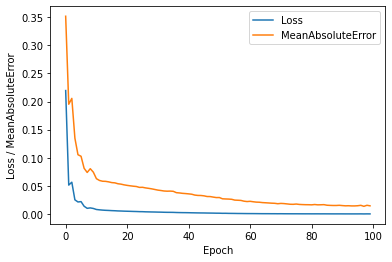

1/1 [==============================] - 0s 108ms/step - loss: 3.4430e-04 - mean_absolute_error: 0.0161
Loss Value Test: 0.00034429781953804195
MeanAbsoluteError Test: 50.604117058217525


In [ ]:
uci_df1 = uci_df.iloc[:-1, :]
uci_df1 = uci_df1.drop(columns = ['target3', 'target5'])

Test_df = uci_df1.loc[index1[0]:index2[0]]
Training_df = uci_df1.drop(uci_df1.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target1']).values.astype(np.float32)
X_test1 = Test_df.drop(columns = ['target1']).values.astype(np.float32)

y_train = Training_df[['target1']].values.astype(np.float32)
y_test1 = Test_df[['target1']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))


model_uci1 = tf.keras.models.Sequential()
model_uci1.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_uci1.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_uci1.add(tf.keras.layers.Flatten())
model_uci1.add(tf.keras.layers.Dense(50, activation='relu'))
model_uci1.add(tf.keras.layers.Dense(1))

model_uci1.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_uci1.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_uci1.evaluate(X_test1, y_test1)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_uci-min_uci)+min_uci))

### Uci Setmana 3

Epoch 1/150
4/4 [==============================] - 0s 3ms/step - loss: 0.1789 - mean_absolute_error: 0.3183
Epoch 2/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0572 - mean_absolute_error: 0.1947
Epoch 3/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0590 - mean_absolute_error: 0.2153
Epoch 4/150
4/4 [==============================] - 0s 4ms/step - loss: 0.0534 - mean_absolute_error: 0.2038
Epoch 5/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0427 - mean_absolute_error: 0.1720
Epoch 6/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0405 - mean_absolute_error: 0.1521
Epoch 7/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0373 - mean_absolute_error: 0.1433
Epoch 8/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0335 - mean_absolute_error: 0.1425
Epoch 9/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0315 - mean_absolute_error: 0.1413
Epoch 10/150
4/4 [==========

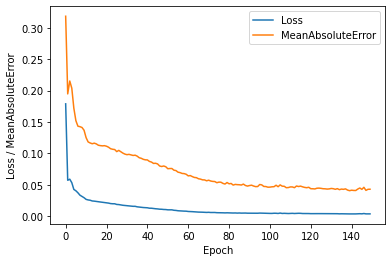

1/1 [==============================] - 0s 109ms/step - loss: 0.0034 - mean_absolute_error: 0.0486
Loss Value Test: 0.0034331446513533592
MeanAbsoluteError Test: 152.49709000065923


In [ ]:
uci_df3 = uci_df.iloc[:-3, :]
uci_df3 = uci_df3.drop(columns = ['target1', 'target5'])

Test_df = uci_df3.loc[index1[0]:index2[0]]
Training_df = uci_df3.drop(uci_df3.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target3']).values.astype(np.float32)
X_test3 = Test_df.drop(columns = ['target3']).values.astype(np.float32)

y_train = Training_df[['target3']].values.astype(np.float32)
y_test3 = Test_df[['target3']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))


model_uci3 = tf.keras.models.Sequential()
model_uci3.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_uci3.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_uci3.add(tf.keras.layers.Flatten())
model_uci3.add(tf.keras.layers.Dense(50, activation='relu'))
model_uci3.add(tf.keras.layers.Dense(1))

model_uci3.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_uci3.fit(X_train, y_train, epochs=150, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_uci3.evaluate(X_test3, y_test3)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_uci-min_uci)+min_uci))

### Uci Setmana 5

Epoch 1/150
4/4 [==============================] - 0s 4ms/step - loss: 0.0645 - mean_absolute_error: 0.1924
Epoch 2/150
4/4 [==============================] - 0s 4ms/step - loss: 0.0587 - mean_absolute_error: 0.2014
Epoch 3/150
4/4 [==============================] - 0s 4ms/step - loss: 0.0459 - mean_absolute_error: 0.1569
Epoch 4/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0405 - mean_absolute_error: 0.1579
Epoch 5/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0394 - mean_absolute_error: 0.1676
Epoch 6/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0360 - mean_absolute_error: 0.1485
Epoch 7/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0351 - mean_absolute_error: 0.1477
Epoch 8/150
4/4 [==============================] - 0s 3ms/step - loss: 0.0338 - mean_absolute_error: 0.1515
Epoch 9/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0331 - mean_absolute_error: 0.1465
Epoch 10/150
4/4 [==========

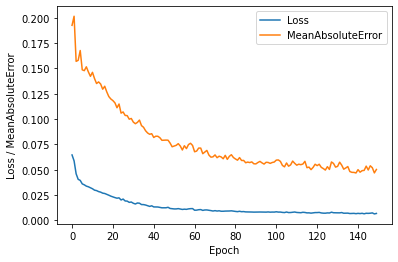

1/1 [==============================] - 0s 116ms/step - loss: 0.0078 - mean_absolute_error: 0.0618
Loss Value Test: 0.007810233160853386
MeanAbsoluteError Test: 194.21900280565023


In [ ]:
uci_df5 = uci_df.iloc[:-5, :]
uci_df5 = uci_df5.drop(columns = ['target1', 'target3'])

Test_df = uci_df5.loc[index1[0]:index2[0]]
Training_df = uci_df5.drop(uci_df5.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target5']).values.astype(np.float32)
X_test5 = Test_df.drop(columns = ['target5']).values.astype(np.float32)

y_train = Training_df[['target5']].values.astype(np.float32)
y_test5 = Test_df[['target5']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))


model_uci5 = tf.keras.models.Sequential()
model_uci5.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_uci5.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_uci5.add(tf.keras.layers.Flatten())
model_uci5.add(tf.keras.layers.Dense(50, activation='relu'))
model_uci5.add(tf.keras.layers.Dense(1))

model_uci5.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_uci5.fit(X_train, y_train, epochs=150, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_uci5.evaluate(X_test5, y_test5)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_uci-min_uci)+min_uci))

### Visualization

1/1 [==============================] - 0s 65ms/step
Mean Absolute Error 1 Week:  47.765366
Mean Absolute Error 3 Week:  109.71803
Mean Absolute Error 5 Week:  169.6654


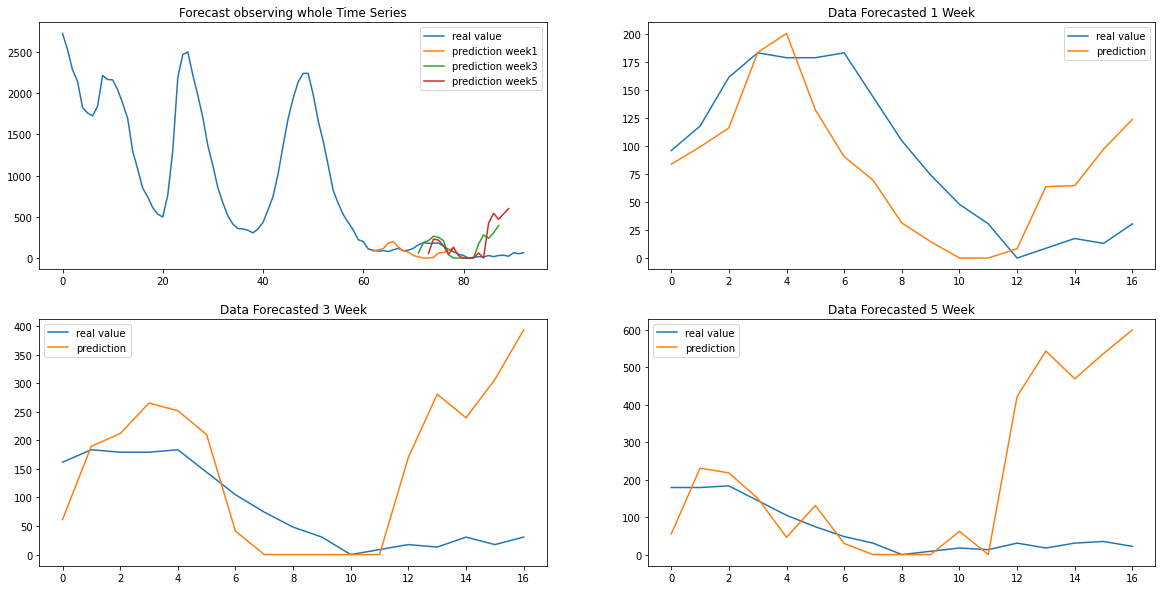

In [ ]:
#create the prediction
y_pred1 = model_uci1.predict(X_test1)
y_pred3 = model_uci3.predict(X_test3)
y_pred5 = model_uci5.predict(X_test5)

y_pred1[y_pred1<0]=0
y_pred3[y_pred3<0]=0
y_pred5[y_pred5<0]=0

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
#plt.plot(y_test*(max_casos-min_casos)+min_casos, label = 'real value')
axs[0,0].plot(np.arange(0, len(uci_df)), uci_df['uci']*(max_uci-min_uci)+min_uci, label = 'real value')
start_index1 = np.where(uci_df['uci'].values.astype(np.float32) == y_test1[0][0])
start_index3 = np.where(uci_df['uci'].values.astype(np.float32) == y_test3[0][0])
start_index5 = np.where(uci_df['uci'].values.astype(np.float32) == y_test5[0][0])
axs[0,0].plot(np.arange(start_index1[0][0], len(y_pred1)+start_index1[0][0]), y_pred1*(max_uci-min_uci)+min_uci, label = 'prediction week1')
axs[0,0].plot(np.arange(start_index3[0][0], len(y_pred3)+start_index3[0][0]), y_pred3*(max_uci-min_uci)+min_uci, label = 'prediction week3')
axs[0,0].plot(np.arange(start_index5[0][0], len(y_pred5)+start_index5[0][0]), y_pred5*(max_uci-min_uci)+min_uci, label = 'prediction week5')
axs[0,0].legend()
axs[0,0].set_title("Forecast observing whole Time Series")

axs[0,1].plot(y_test1*(max_uci-min_uci)+min_uci, label = 'real value')
axs[0,1].plot(y_pred1*(max_uci-min_uci)+min_uci, label = 'prediction')
axs[0,1].legend()
axs[0,1].set_title("Data Forecasted 1 Week")

axs[1,0].plot(y_test3*(max_uci-min_uci)+min_uci, label = 'real value')
axs[1,0].plot(y_pred3*(max_uci-min_uci)+min_uci, label = 'prediction')
axs[1,0].legend()
axs[1,0].set_title("Data Forecasted 3 Week")

axs[1,1].plot(y_test5*(max_uci-min_uci)+min_uci, label = 'real value')
axs[1,1].plot(y_pred5*(max_uci-min_uci)+min_uci, label = 'prediction')
axs[1,1].legend()
axs[1,1].set_title("Data Forecasted 5 Week")
print("Mean Absolute Error 1 Week: " , np.mean(abs(y_test1 - y_pred1)*(max_uci-min_uci)+min_uci))
print("Mean Absolute Error 3 Week: " , np.mean(abs(y_test3 - y_pred3)*(max_uci-min_uci)+min_uci))
print("Mean Absolute Error 5 Week: " , np.mean(abs(y_test5 - y_pred5)*(max_uci-min_uci)+min_uci))

## Defuncions

In [ ]:
deaths_df = dataset_training[['data_inici', 'casos', 'hospitalitzacions', 'uci', 'defuncions', 'holidays', 'toc_queda', 'mascareta', 'temperature']]
deaths_df['data_inici'] = pd.to_datetime(deaths_df['data_inici'], format = "%Y/%m/%d")

max_deaths = deaths_df.hospitalitzacions.max()
min_deaths = deaths_df.hospitalitzacions.min()

# El test es fa en la sisena onada, durant les dates 30/05/2022 - 19/09/2022
index1 = deaths_df.index[deaths_df['data_inici'] == datetime.datetime(2022, 5, 30)]
index2 = deaths_df.index[deaths_df['data_inici'] == datetime.datetime(2022, 9, 19)]
deaths_df = deaths_df.drop(columns = ['data_inici'])

deaths_df = (deaths_df-deaths_df.min())/(deaths_df.max()-deaths_df.min())


#We create the columns with the values of the previous weeks --> attributes
deaths_df['uci-1'] = deaths_df['uci'].shift(1)
deaths_df['uci-2'] = deaths_df['uci'].shift(2)
deaths_df['uci-3'] = deaths_df['uci'].shift(3)
deaths_df['uci-4'] = deaths_df['uci'].shift(4)
deaths_df['uci-5'] = deaths_df['uci'].shift(5)

deaths_df['hosp-1'] = deaths_df['hospitalitzacions'].shift(1)

deaths_df['defuncions-1'] = deaths_df['defuncions'].shift(1)
deaths_df['defuncions-2'] = deaths_df['defuncions'].shift(2)
deaths_df['defuncions-3'] = deaths_df['defuncions'].shift(3)
deaths_df['defuncions-4'] = deaths_df['defuncions'].shift(4)
deaths_df['defuncions-5'] = deaths_df['defuncions'].shift(5)


#We create the target column with the predictions for next week
deaths_df['target1'] = deaths_df['defuncions'].shift(-1)
deaths_df['target3'] = deaths_df['defuncions'].shift(-3)
deaths_df['target5'] = deaths_df['defuncions'].shift(-5)

deaths_df = deaths_df.iloc[5:,:]
deaths_df.head()

<ipython-input-29-b0fc04a38445>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_df['data_inici'] = pd.to_datetime(deaths_df['data_inici'], format = "%Y/%m/%d")


,casos,hospitalitzacions,uci,defuncions,holidays,toc_queda,mascareta,temperature,uci-1,uci-2,...,uci-5,hosp-1,defuncions-1,defuncions-2,defuncions-3,defuncions-4,defuncions-5,target1,target3,target5
5,0.080810,0.753582,0.867872,0.565068,0.0,1.0,1.0,0.041958,0.952712,1.000000,...,0.641168,0.875836,0.736301,1.000000,0.958904,0.830479,0.642123,0.453767,0.297945,0.188356
6,0.075064,0.642471,0.805285,0.453767,0.0,1.0,1.0,0.041958,0.867872,0.952712,...,0.752434,0.753582,0.565068,0.736301,1.000000,0.958904,0.830479,0.327055,0.253425,0.183219
7,0.066914,0.563196,0.727399,0.327055,0.0,1.0,1.0,0.041958,0.805285,0.867872,...,0.937413,0.642471,0.453767,0.565068,0.736301,1.000000,0.958904,0.297945,0.188356,0.236301
8,0.061045,0.518625,0.682893,0.297945,0.0,1.0,1.0,0.167832,0.727399,0.805285,...,1.000000,0.563196,0.327055,0.453767,0.565068,0.736301,1.000000,0.253425,0.183219,0.251712
9,0.058162,0.490608,0.581363,0.253425,0.0,1.0,1.0,0.167832,0.682893,0.727399,...,0.952712,0.518625,0.297945,0.327055,0.453767,0.565068,0.736301,0.188356,0.236301,0.232877


### Defuncions Setmana 1

Epoch 1/100
4/4 [==============================] - 1s 3ms/step - loss: 0.0452 - mean_absolute_error: 0.1618
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0984
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0964
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0595
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0531
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0481
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0354
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0346
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0342
Epoch 10/100
4/4 [==========

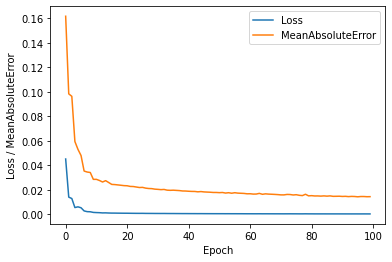

1/1 [==============================] - 0s 118ms/step - loss: 0.0024 - mean_absolute_error: 0.0395
Loss Value Test: 0.0024038152769207954
MeanAbsoluteError Test: 124.04919253662229


In [ ]:
deaths_df1 = deaths_df.iloc[:-1, :]
deaths_df1 = deaths_df1.drop(columns = ['target3', 'target5'])

Test_df = deaths_df1.loc[index1[0]:index2[0]]
Training_df = deaths_df1.drop(deaths_df1.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target1']).values.astype(np.float32)
X_test1 = Test_df.drop(columns = ['target1']).values.astype(np.float32)

y_train = Training_df[['target1']].values.astype(np.float32)
y_test1 = Test_df[['target1']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_deaths1 = tf.keras.models.Sequential()
model_deaths1.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_deaths1.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_deaths1.add(tf.keras.layers.Flatten())
model_deaths1.add(tf.keras.layers.Dense(50, activation='relu'))
model_deaths1.add(tf.keras.layers.Dense(1))

model_deaths1.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_deaths1.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_deaths1.evaluate(X_test1, y_test1)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_deaths-min_deaths)+min_deaths))

### Defuncions Setmana 3

Epoch 1/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0312 - mean_absolute_error: 0.1501
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0259 - mean_absolute_error: 0.1327
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_error: 0.0914
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_error: 0.0770
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_error: 0.0741
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0068 - mean_absolute_error: 0.0672
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0600
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0623
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0594
Epoch 10/100
4/4 [==========

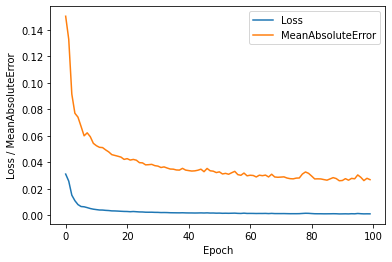

1/1 [==============================] - 0s 131ms/step - loss: 0.0158 - mean_absolute_error: 0.1113
Loss Value Test: 0.015789583325386047
MeanAbsoluteError Test: 349.5822511687875


In [ ]:
deaths_df3 = deaths_df.iloc[:-3, :]
deaths_df3 = deaths_df3.drop(columns = ['target1', 'target5'])

Test_df = deaths_df3.loc[index1[0]:index2[0]]
Training_df = deaths_df3.drop(deaths_df3.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target3']).values.astype(np.float32)
X_test3 = Test_df.drop(columns = ['target3']).values.astype(np.float32)

y_train = Training_df[['target3']].values.astype(np.float32)
y_test3 = Test_df[['target3']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_deaths3 = tf.keras.models.Sequential()
model_deaths3.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_deaths3.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_deaths3.add(tf.keras.layers.Flatten())
model_deaths3.add(tf.keras.layers.Dense(50, activation='relu'))
model_deaths3.add(tf.keras.layers.Dense(1))

model_deaths3.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_deaths3.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_deaths3.evaluate(X_test3, y_test3)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_deaths-min_deaths)+min_deaths))

### Defuncions Setmana 5

Epoch 1/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0212 - mean_absolute_error: 0.1155
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0137 - mean_absolute_error: 0.1004
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0122 - mean_absolute_error: 0.0842
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0115 - mean_absolute_error: 0.0956
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0734
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0680
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0690
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0637
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0617
Epoch 10/100
4/4 [==========

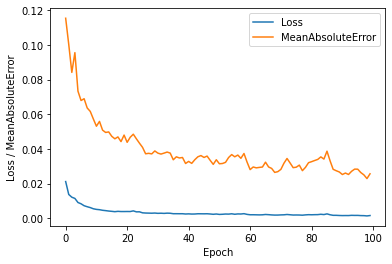

1/1 [==============================] - 0s 114ms/step - loss: 0.0498 - mean_absolute_error: 0.2001
Loss Value Test: 0.049836404621601105
MeanAbsoluteError Test: 628.4948312044144


In [ ]:
deaths_df5 = deaths_df.iloc[:-5, :]
deaths_df5 = deaths_df5.drop(columns = ['target1', 'target3'])

Test_df = deaths_df5.loc[index1[0]:index2[0]]
Training_df = deaths_df5.drop(deaths_df5.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target5']).values.astype(np.float32)
X_test5 = Test_df.drop(columns = ['target5']).values.astype(np.float32)

y_train = Training_df[['target5']].values.astype(np.float32)
y_test5 = Test_df[['target5']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_deaths5 = tf.keras.models.Sequential()
model_deaths5.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_deaths5.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_deaths5.add(tf.keras.layers.Flatten())
model_deaths5.add(tf.keras.layers.Dense(50, activation='relu'))
model_deaths5.add(tf.keras.layers.Dense(1))

model_deaths5.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_deaths5.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_deaths5.evaluate(X_test5, y_test5)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_deaths-min_deaths)+min_deaths))

### Visualization

1/1 [==============================] - 0s 69ms/step
Mean Absolute Error 1 Week:  124.04922
Mean Absolute Error 3 Week:  349.58224
Mean Absolute Error 5 Week:  628.4948


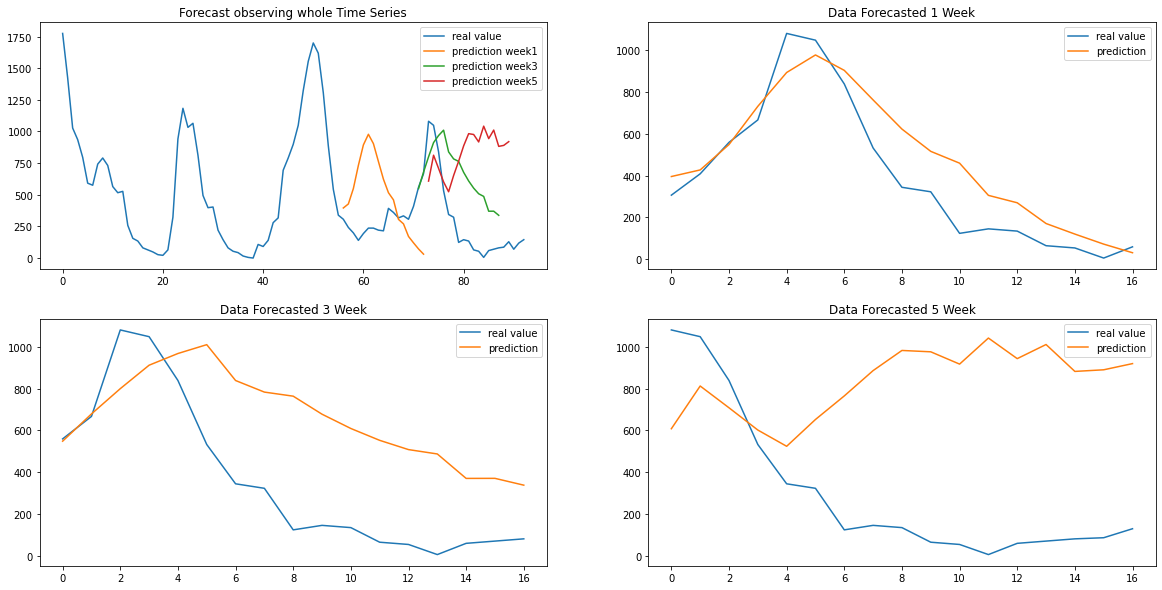

In [ ]:
#create the prediction
y_pred1 = model_deaths1.predict(X_test1)
y_pred3 = model_deaths3.predict(X_test3)
y_pred5 = model_deaths5.predict(X_test5)

y_pred1[y_pred1<0]=0
y_pred3[y_pred3<0]=0
y_pred5[y_pred5<0]=0

fig, axs = plt.subplots(2, 2, figsize = (20, 10))
#plt.plot(y_test*(max_casos-min_casos)+min_casos, label = 'real value')
axs[0,0].plot(np.arange(0, len(deaths_df)), deaths_df['defuncions']*(max_deaths-min_deaths)+min_deaths, label = 'real value')
start_index1 = np.where(deaths_df['defuncions'].values.astype(np.float32) == y_test1[0][0])
start_index3 = np.where(deaths_df['defuncions'].values.astype(np.float32) == y_test3[0][0])
start_index5 = np.where(deaths_df['defuncions'].values.astype(np.float32) == y_test5[0][0])
axs[0,0].plot(np.arange(start_index1[0][0], len(y_pred1)+start_index1[0][0]), y_pred1*(max_deaths-min_deaths)+min_deaths, label = 'prediction week1')
axs[0,0].plot(np.arange(start_index3[0][0], len(y_pred3)+start_index3[0][0]), y_pred3*(max_deaths-min_deaths)+min_deaths, label = 'prediction week3')
axs[0,0].plot(np.arange(start_index5[0][0], len(y_pred5)+start_index5[0][0]), y_pred5*(max_deaths-min_deaths)+min_deaths, label = 'prediction week5')
axs[0,0].legend()
axs[0,0].set_title("Forecast observing whole Time Series")

axs[0,1].plot(y_test1*(max_deaths-min_deaths)+min_deaths, label = 'real value')
axs[0,1].plot(y_pred1*(max_deaths-min_deaths)+min_deaths, label = 'prediction')
axs[0,1].legend()
axs[0,1].set_title("Data Forecasted 1 Week")

axs[1,0].plot(y_test3*(max_deaths-min_deaths)+min_deaths, label = 'real value')
axs[1,0].plot(y_pred3*(max_deaths-min_deaths)+min_deaths, label = 'prediction')
axs[1,0].legend()
axs[1,0].set_title("Data Forecasted 3 Week")

axs[1,1].plot(y_test5*(max_deaths-min_deaths)+min_deaths, label = 'real value')
axs[1,1].plot(y_pred5*(max_deaths-min_deaths)+min_deaths, label = 'prediction')
axs[1,1].legend()
axs[1,1].set_title("Data Forecasted 5 Week")
print("Mean Absolute Error 1 Week: " , np.mean(abs(y_test1 - y_pred1)*(max_deaths-min_deaths)+min_deaths))
print("Mean Absolute Error 3 Week: " , np.mean(abs(y_test3 - y_pred3)*(max_deaths-min_deaths)+min_deaths))
print("Mean Absolute Error 5 Week: " , np.mean(abs(y_test5 - y_pred5)*(max_deaths-min_deaths)+min_deaths))

## Analisi Models

In [ ]:
instance = casos_df.iloc[[0]]
instance = instance.drop(columns = ['target1', 'target3', 'target5'])

model_casos1.predict(instance.values)[0][0]*(max_casos-min_casos)+min_casos

1/1 [==============================] - 0s 28ms/step


20295.830310463905

In [ ]:
mascareta_df = casos_df.iloc[[0]].copy().drop(columns = ['target1', 'target3', 'target5'])
mascareta['mascareta'] = 0
mascareta_df = mascareta_df.append(mascareta, ignore_index = True)

toc_queda_df = casos_df.iloc[[0]].copy().drop(columns = ['target1', 'target3', 'target5'])
toc_queda['toc_queda'] = 0
toc_queda_df = toc_queda_df.append(toc_queda, ignore_index = True)

holidays_df = casos_df.iloc[[0]].copy().drop(columns = ['target1', 'target3', 'target5'])
holidays['holidays'] = 1
holidays_df = holidays_df.append(holidays, ignore_index = True)

temperature_df = casos_df.iloc[[0]].copy().drop(columns = ['target1', 'target3', 'target5'])
temperature1 = instance.iloc[0].copy()
temperature2 = instance.iloc[0].copy()
temperature1['temperature'] = 0
temperature2['temperature'] = 1
temperature_df = temperature_df.append([temperature1, temperature2], ignore_index = True)

mascareta_predict1 = model_casos1.predict(mascareta_df.values)*(max_casos-min_casos)+min_casos
mascareta_predict3 = model_casos3.predict(mascareta_df.values)*(max_casos-min_casos)+min_casos
mascareta_predict5 = model_casos5.predict(mascareta_df.values)*(max_casos-min_casos)+min_casos

toc_queda_predict1 = model_casos1.predict(toc_queda_df.values)*(max_casos-min_casos)+min_casos
toc_queda_predict3 = model_casos3.predict(toc_queda_df.values)*(max_casos-min_casos)+min_casos
toc_queda_predict5 = model_casos5.predict(toc_queda_df.values)*(max_casos-min_casos)+min_casos

holidays_predict1 = model_casos1.predict(holidays_df.values)*(max_casos-min_casos)+min_casos
holidays_predict3 = model_casos3.predict(holidays_df.values)*(max_casos-min_casos)+min_casos
holidays_predict5 = model_casos5.predict(holidays_df.values)*(max_casos-min_casos)+min_casos

temperature_predict1 = model_casos1.predict(temperature_df.values)*(max_casos-min_casos)+min_casos
temperature_predict3 = model_casos3.predict(temperature_df.values)*(max_casos-min_casos)+min_casos
temperature_predict5 = model_casos5.predict(temperature_df.values)*(max_casos-min_casos)+min_casos


1/1 [==============================] - 0s 51ms/step


In [ ]:
mascareta_predict1 = [item for sublist in mascareta_predict1 for item in sublist]
mascareta_predict3 = [item for sublist in mascareta_predict3 for item in sublist]
mascareta_predict5 = [item for sublist in mascareta_predict5 for item in sublist]

mascareta_pred_df = pd.DataFrame({'prediccio1': mascareta_predict1, 'prediccio3': mascareta_predict3, 
                                  'prediccio5': mascareta_predict5, 'mascareta':[1,0]})

toc_queda_predict1 = [item for sublist in toc_queda_predict1 for item in sublist]
toc_queda_predict3 = [item for sublist in toc_queda_predict3 for item in sublist]
toc_queda_predict5 = [item for sublist in toc_queda_predict5 for item in sublist]

toc_queda_predict_df = pd.DataFrame({'prediccio1': toc_queda_predict1, 'prediccio3': toc_queda_predict3, 
                                  'prediccio5': toc_queda_predict5, 'toc_queda':[1,0]})

holidays_predict1 = [item for sublist in holidays_predict1 for item in sublist]
holidays_predict3 = [item for sublist in holidays_predict3 for item in sublist]
holidays_predict5 = [item for sublist in holidays_predict5 for item in sublist]

holidays_predict_df = pd.DataFrame({'prediccio1': holidays_predict1, 'prediccio3': holidays_predict3, 
                                  'prediccio5': holidays_predict5, 'holidays':[0,1]})

temperature_predict1 = [item for sublist in temperature_predict1 for item in sublist]
temperature_predict3 = [item for sublist in temperature_predict3 for item in sublist]
temperature_predict5 = [item for sublist in temperature_predict5 for item in sublist]

temperature_predict_df = pd.DataFrame({'prediccio1': temperature_predict1, 'prediccio3': temperature_predict3, 
                                  'prediccio5': temperature_predict5, 'temperatura':[0.42,0, 1]})


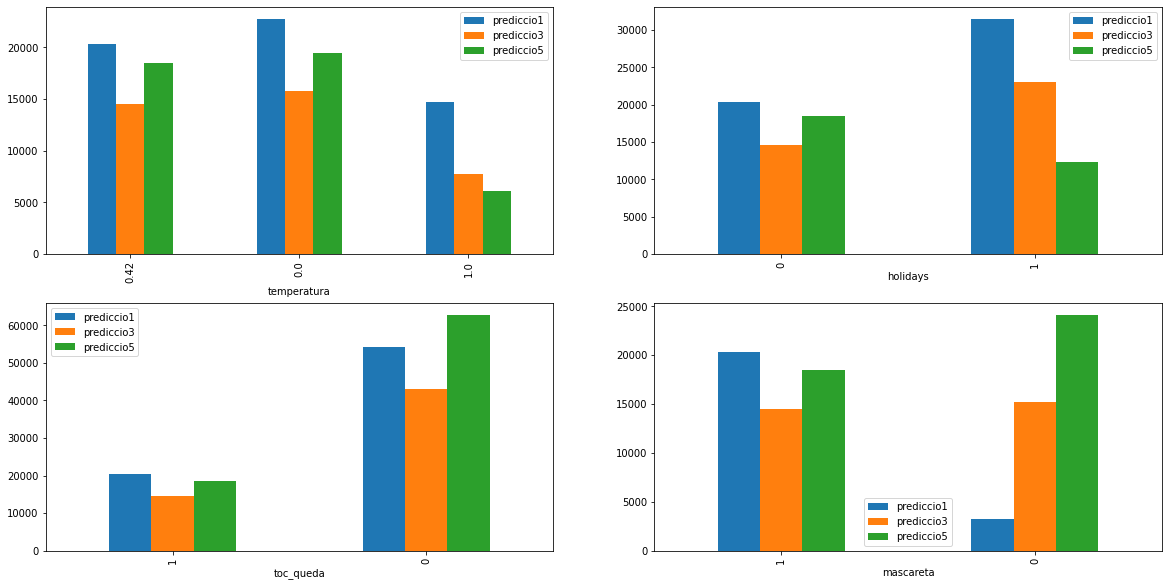

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
temperature_predict_df.plot(x="temperatura", y=['prediccio1', 'prediccio3', 'prediccio5'], kind="bar", ax = axs[0,0])
holidays_predict_df.plot(x="holidays", y=['prediccio1', 'prediccio3', 'prediccio5'], kind="bar", ax = axs[0,1])
toc_queda_predict_df.plot(x="toc_queda", y=['prediccio1', 'prediccio3', 'prediccio5'], kind="bar", ax = axs[1,0])
mascareta_pred_df.plot(x="mascareta", y=['prediccio1', 'prediccio3', 'prediccio5'], kind="bar", ax = axs[1,1])


## Prova amb Vacunacio Hospitalitzacions

In [ ]:
dataset_training_vac


,data_inici,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster,holidays,toc_queda,mascareta,temperature
0,2021-01-04,29299,2423,470,385,0.0000,0.0000,1,1,1,11.8
1,2021-01-11,33988,2832,550,495,0.0000,0.0000,0,1,1,11.8
2,2021-01-18,32377,3075,683,570,0.0000,0.0000,0,1,1,11.8
3,2021-01-25,30413,3141,728,594,0.0010,0.0000,0,1,1,11.8
4,2021-02-01,25592,2751,694,440,0.0082,0.0000,0,1,1,12.4
...,...,...,...,...,...,...,...,...,...,...,...
77,2022-06-27,44997,2139,51,134,0.8323,0.4452,0,0,0,23.0
78,2022-07-04,41190,2015,50,211,0.8325,0.4472,0,0,0,25.7
79,2022-07-11,29451,1805,50,205,0.8328,0.4493,0,0,0,25.7
80,2022-07-18,15677,1530,51,166,0.8330,0.4513,0,0,0,25.7


In [ ]:
deaths_df = dataset_training[['casos', 'hospitalitzacions', 'uci', 'defuncions', 'pauta_completa','booster','holidays', 'toc_queda', 'mascareta', 'temperature']]

max_deaths = deaths_df.hospitalitzacions.max()
min_deaths = deaths_df.hospitalitzacions.min()


deaths_df = (deaths_df-deaths_df.min())/(deaths_df.max()-deaths_df.min())


#We create the columns with the values of the previous weeks --> attributes
deaths_df['uci-1'] = deaths_df['uci'].shift(1)
deaths_df['uci-2'] = deaths_df['uci'].shift(2)
deaths_df['uci-3'] = deaths_df['uci'].shift(3)
deaths_df['uci-4'] = deaths_df['uci'].shift(4)
deaths_df['uci-5'] = deaths_df['uci'].shift(5)

deaths_df['hosp-1'] = deaths_df['hospitalitzacions'].shift(1)

deaths_df['defuncions-1'] = deaths_df['defuncions'].shift(1)
deaths_df['defuncions-2'] = deaths_df['defuncions'].shift(2)
deaths_df['defuncions-3'] = deaths_df['defuncions'].shift(3)
deaths_df['defuncions-4'] = deaths_df['defuncions'].shift(4)
deaths_df['defuncions-5'] = deaths_df['defuncions'].shift(5)


#We create the target column with the predictions for next week
deaths_df['target1'] = deaths_df['defuncions'].shift(-1)
deaths_df['target3'] = deaths_df['defuncions'].shift(-3)
deaths_df['target5'] = deaths_df['defuncions'].shift(-5)

deaths_df = deaths_df.iloc[5:,:]
deaths_df.head()

,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster,holidays,toc_queda,mascareta,temperature,...,uci-5,hosp-1,defuncions-1,defuncions-2,defuncions-3,defuncions-4,defuncions-5,target1,target3,target5
5,0.080810,0.753582,0.867872,0.565068,0.019803,0.0,0.0,1.0,1.0,0.041958,...,0.641168,0.875836,0.736301,1.000000,0.958904,0.830479,0.642123,0.453767,0.297945,0.188356
6,0.075064,0.642471,0.805285,0.453767,0.026164,0.0,0.0,1.0,1.0,0.041958,...,0.752434,0.753582,0.565068,0.736301,1.000000,0.958904,0.830479,0.327055,0.253425,0.183219
7,0.066914,0.563196,0.727399,0.327055,0.028325,0.0,0.0,1.0,1.0,0.041958,...,0.937413,0.642471,0.453767,0.565068,0.736301,1.000000,0.958904,0.297945,0.188356,0.236301
8,0.061045,0.518625,0.682893,0.297945,0.029645,0.0,0.0,1.0,1.0,0.167832,...,1.000000,0.563196,0.327055,0.453767,0.565068,0.736301,1.000000,0.253425,0.183219,0.251712
9,0.058162,0.490608,0.581363,0.253425,0.031805,0.0,0.0,1.0,1.0,0.167832,...,0.952712,0.518625,0.297945,0.327055,0.453767,0.565068,0.736301,0.188356,0.236301,0.232877


### Setmana 1

Epoch 1/100
3/3 [==============================] - 0s 5ms/step - loss: 0.1142 - mean_absolute_error: 0.2460
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0692 - mean_absolute_error: 0.2170
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0592 - mean_absolute_error: 0.2080
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0534 - mean_absolute_error: 0.1993
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0434 - mean_absolute_error: 0.1773
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0348 - mean_absolute_error: 0.1562
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0298 - mean_absolute_error: 0.1383
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0263 - mean_absolute_error: 0.1259
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0230 - mean_absolute_error: 0.1178
Epoch 10/100
3/3 [==========

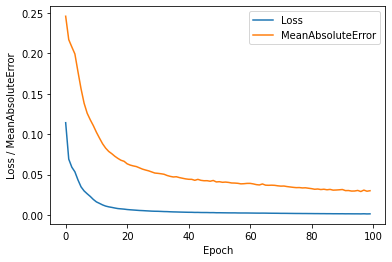

1/1 [==============================] - 0s 127ms/step - loss: 0.0024 - mean_absolute_error: 0.0354
Loss Value Test: 0.002384440042078495
MeanAbsoluteError Test: 111.22107241675258


In [ ]:
from sklearn.model_selection import train_test_split

deaths_df1 = deaths_df.iloc[:-1, :]
deaths_df1 = deaths_df1.drop(columns = ['target3', 'target5'])

#Test_df = hosp_df1[index1:-1]
#Training_df = hosp_df1.drop(hosp_df1.index[index1:-1])
Training_df, Test_df = train_test_split(hosp_df1, test_size=0.2, random_state=42)

X_train = Training_df.drop(columns = ['target1']).values.astype(np.float32)
X_test1 = Test_df.drop(columns = ['target1']).values.astype(np.float32)

y_train = Training_df[['target1']].values.astype(np.float32)
y_test1 = Test_df[['target1']].values.astype(np.float32)

n_features = 1
n_outputs = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

model_hosp1 = tf.keras.models.Sequential()
model_hosp1.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_hosp1.add(tf.keras.layers.MaxPooling1D(pool_size=1))
model_hosp1.add(tf.keras.layers.Flatten())
model_hosp1.add(tf.keras.layers.Dense(50, activation='relu'))
model_hosp1.add(tf.keras.layers.Dense(1))

model_hosp1.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

history = model_hosp1.fit(X_train, y_train, epochs=100, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model_hosp1.evaluate(X_test1, y_test1)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_deaths-min_deaths)+min_deaths))

10

In [ ]:
hosp_df1

,casos,hospitalitzacions,pauta_completa,booster,cases-1,cases-2,cases-3,cases-4,cases-5,hosp-1,hosp-2,hosp-3,hosp-4,hosp-5,target1
5,0.072336,0.725629,0.019803,0.000000,0.098019,0.121275,0.130750,0.138521,0.115901,0.861751,1.000000,0.976604,0.890464,0.745480,0.601914
6,0.066537,0.601914,0.026164,0.000000,0.072336,0.098019,0.121275,0.130750,0.138521,0.725629,0.861751,1.000000,0.976604,0.890464,0.513648
7,0.058312,0.513648,0.028325,0.000000,0.066537,0.072336,0.098019,0.121275,0.130750,0.601914,0.725629,0.861751,1.000000,0.976604,0.464020
8,0.052389,0.464020,0.029645,0.000000,0.058312,0.066537,0.072336,0.098019,0.121275,0.513648,0.601914,0.725629,0.861751,1.000000,0.432825
9,0.049480,0.432825,0.031805,0.000000,0.052389,0.058312,0.066537,0.072336,0.098019,0.464020,0.513648,0.601914,0.725629,0.861751,0.389578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.155067,0.557604,0.998560,0.979695,0.107483,0.074010,0.066340,0.060421,0.080990,0.418291,0.346686,0.304502,0.294931,0.296703,0.644807
77,0.191628,0.644807,0.998920,0.982565,0.155067,0.107483,0.074010,0.066340,0.060421,0.557604,0.418291,0.346686,0.304502,0.294931,0.600851
78,0.173263,0.600851,0.999160,0.986979,0.191628,0.155067,0.107483,0.074010,0.066340,0.644807,0.557604,0.418291,0.346686,0.304502,0.526409
79,0.116635,0.526409,0.999520,0.991613,0.173263,0.191628,0.155067,0.107483,0.074010,0.600851,0.644807,0.557604,0.418291,0.346686,0.428926
